In [1]:
import json
import pickle
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

import clip
import ruclip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

import utils
from dataset import ImageDataset

In [2]:
# преобразования изображений для обучения
train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# преобразования изображений для инференса
test_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Тестовые запросы

In [3]:
# загружаем json-файл с тестовыми запросами и релевантными изображениями
with open('semantic_test_queries.json') as file:
    queries_and_relevants = json.load(file)
    queries = list(queries_and_relevants.keys())

# приведем к более удобной структуре
for query in queries:
    df_query = pd.DataFrame(queries_and_relevants[query])
    ids = df_query['id'].tolist()
    paths = df_query['local_image_path'].tolist()
    texts = df_query['text'].tolist()
    queries_and_relevants[query] = {'ids': ids, 'paths': paths, 'texts': texts}

# CLIP

## Finetuning

In [7]:
# загружаем предобученную модель
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'clip'
model, processor = clip.load('ViT-B/32', device=device)

# замораживаем оригинальные слои
for param in model.parameters():
    param.requires_grad = False

# размораживаем проекторы
model.text_projection.requires_grad = True
model.visual.proj.requires_grad = True

In [8]:
# создаем датасеты и даталоадеры
batch_size = 128
train_dataset = ImageDataset('data/train_data.csv', model_name, train_transform, processor)
test_dataset = ImageDataset('data/test_data.csv', model_name, test_transform, processor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# задаем оптимизатор, скедулер и скейлер
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
scaler = torch.amp.GradScaler(device)

# определяем функции потерь
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [9]:
# запускаем дообучение модели
clip_logs = utils.clip_training_loop(
    5, model, model_name, train_dataloader, test_dataloader,
    loss_img, loss_txt, optimizer, scheduler, scaler, device
)

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 0/5, Loss: 2.1758: 100%|██████████| 163/163 [07:32<00:00,  2.78s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.0512


Epoch 1/5, Loss: 1.6953: 100%|██████████| 163/163 [06:05<00:00,  2.24s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.0688


Epoch 2/5, Loss: 1.3867: 100%|██████████| 163/163 [05:52<00:00,  2.16s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.0773


Epoch 3/5, Loss: 1.4648: 100%|██████████| 163/163 [05:52<00:00,  2.16s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.0831


Epoch 4/5, Loss: 1.2305: 100%|██████████| 163/163 [05:58<00:00,  2.20s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.0905


In [15]:
# сохраняем модель
torch.save(model.state_dict(), 'models/clip_finetuned.pt')

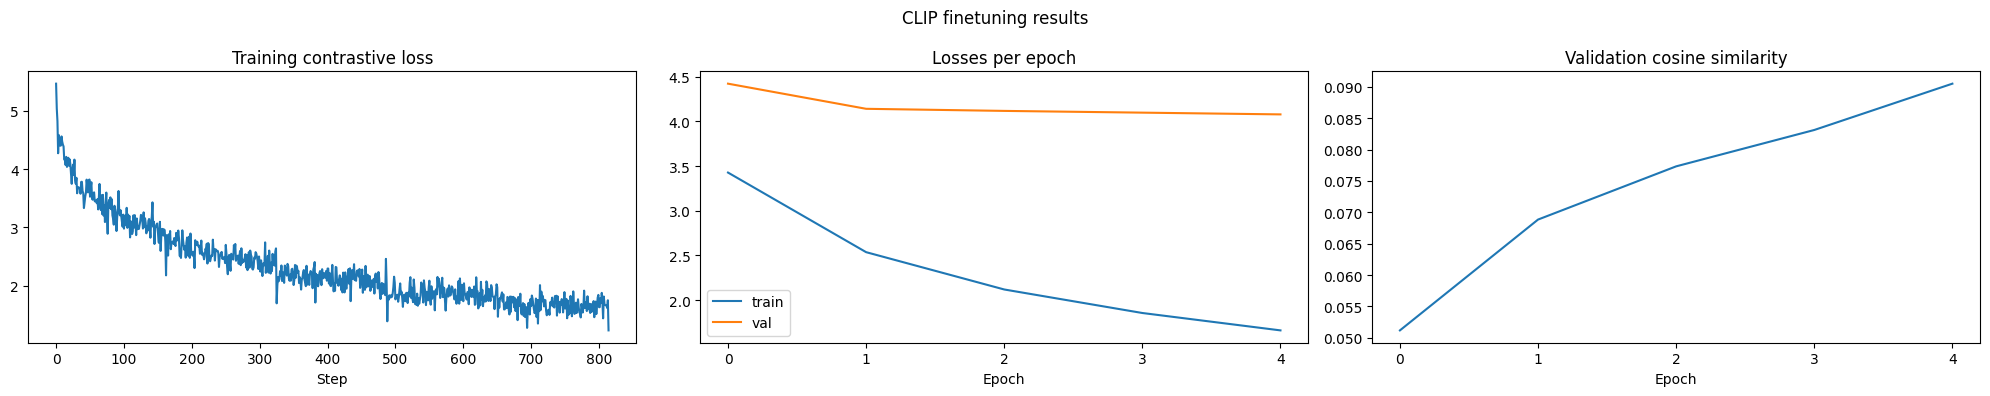

In [ ]:
# визуализируем результаты обучения
utils.plot_training_logs(clip_logs, 'CLIP finetuning results', 'figures/clip-finetuning.png')

## Extraction of embeddings

In [16]:
# получаем эмбеддинги
test_df = pd.read_csv('data/test_data.csv')
total_image_embeddings, total_text_embeddings = utils.get_full_embeddings(test_df, model, processor, model_name, device)

test_data = {
    'ids': test_df['id'].to_list(),
    'image_paths': test_df['local_image_path'].to_list(),
    'image_embeddings': total_image_embeddings,
    'texts': test_df['text'].to_list(),
    'text_embeddings': total_text_embeddings,
    'urls': test_df['url'].to_list()
}

# сохраняем в пикл
with open('embeddings/test_embeddings_clip_finetuned.pkl', 'wb') as file:
    pickle.dump(test_data, file)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


## Evaluation

In [17]:
# загружаем тестовые эмбеддинги
with open('embeddings/test_embeddings_clip_finetuned.pkl', 'rb') as file:
    test_data = pickle.load(file)

# инициализируем модель
model_name = 'clip'
clip_model, preprocess = clip.load('ViT-B/32', device='cpu')
clip_model.load_state_dict(torch.load('models/clip_finetuned.pt', weights_only=True))

# считаем косинусное сходство между эмбеддингами правильных пар
utils.mean_similarity_between_true(clip_model, test_data['image_embeddings'], test_data['text_embeddings'])

Среднее косинусное сходство эмбеддингов у правильных пар: 0.0913


0.09130859375

In [18]:
# проходим по всем тестовым запросам
queries_and_preds = {}
for query in queries:
    text_embedding = utils.get_text_embedding(query, model, preprocess, model_name, device)
    scores = torch.cosine_similarity(text_embedding, test_data['image_embeddings'], dim=-1)
    top_images_indices = torch.topk(scores, k=5).indices
    ids = np.array(test_data['ids'])[top_images_indices].tolist()
    paths = np.array(test_data['image_paths'])[top_images_indices].tolist()
    texts = np.array(test_data['texts'])[top_images_indices].tolist()
    queries_and_preds[query] = {'ids': ids, 'paths': paths, 'texts': texts}

In [19]:
utils.precision_at_k(queries_and_relevants, queries_and_preds)

----- Precision@5 -----
Запрос "котенок":  1.00
Запрос "петух курица":  0.20
Запрос "девушка":  0.60
Запрос "новый год":  0.40
Запрос "пасха":  0.00
Запрос "цветы ромашки":  0.20
Запрос "иероглифы":  0.00
Запрос "персонажи мультфильмов":  0.00
Запрос "космос":  0.20
Запрос "необычные птицы":  0.20
Запрос "ученый и наука":  0.00
Запрос "надписи буквами":  0.40
Запрос "военная":  0.00
Запрос "автомобили машины":  0.20
Запрос "гарри поттер":  0.00
Запрос "бабочка":  0.00
Запрос "собака играет":  0.60
Запрос "знаки зодиака":  0.00
Запрос "лило и стич":  0.00
Запрос "самолеты небо":  0.00
Запрос "детские рисунки":  0.00
Запрос "любовь":  0.20
Запрос "динозавр":  0.00
Запрос "пиво":  0.20
Среднее значение по всем запросам: 0.18333333333333332


In [20]:
utils.recall_at_k(queries_and_relevants, queries_and_preds)

----- Recall@5 -----
Запрос "котенок":  0.31
Запрос "петух курица":  0.06
Запрос "девушка":  0.21
Запрос "новый год":  0.14
Запрос "пасха":  0.00
Запрос "цветы ромашки":  0.07
Запрос "иероглифы":  0.00
Запрос "персонажи мультфильмов":  0.00
Запрос "космос":  0.06
Запрос "необычные птицы":  0.07
Запрос "ученый и наука":  0.00
Запрос "надписи буквами":  0.12
Запрос "военная":  0.00
Запрос "автомобили машины":  0.09
Запрос "гарри поттер":  0.00
Запрос "бабочка":  0.00
Запрос "собака играет":  0.19
Запрос "знаки зодиака":  0.00
Запрос "лило и стич":  0.00
Запрос "самолеты небо":  0.00
Запрос "детские рисунки":  0.00
Запрос "любовь":  0.06
Запрос "динозавр":  0.00
Запрос "пиво":  0.09
Среднее значение по всем запросам: 0.06148614117364118


# ruCLIP

## Finetuning

In [4]:
# загружаем предобученную модель
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'ruclip'
model, processor = ruclip.load('ruclip-vit-base-patch32-224', device=device)

# замораживаем оригинальные слои
for param in model.parameters():
    param.requires_grad = False

# размораживаем проекторы
model.text_projection.requires_grad = True
model.visual.proj.requires_grad = True

/home/student/kholicheva/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


In [5]:
# создаем датасеты и даталоадеры
batch_size = 128
train_dataset = ImageDataset('data/train_data.csv', model_name, train_transform, processor)
test_dataset = ImageDataset('data/test_data.csv', model_name, test_transform, processor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# задаем оптимизатор, скедулер и скейлер
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
scaler = torch.amp.GradScaler(device)

# определяем функции потерь
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [6]:
# запускаем дообучение модели
ruclip_logs = utils.clip_training_loop(
    5, model, model_name, train_dataloader, test_dataloader,
    loss_img, loss_txt, optimizer, scheduler, scaler, device
)

Epoch 0/5, Loss: 1.0102: 100%|██████████| 163/163 [06:17<00:00,  2.32s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.2200


Epoch 1/5, Loss: 0.6631: 100%|██████████| 163/163 [06:19<00:00,  2.33s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.2253


Epoch 2/5, Loss: 0.7202: 100%|██████████| 163/163 [06:15<00:00,  2.30s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.2285


Epoch 3/5, Loss: 0.5363: 100%|██████████| 163/163 [06:17<00:00,  2.32s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.2326


Epoch 4/5, Loss: 0.4402: 100%|██████████| 163/163 [06:17<00:00,  2.32s/it]


Среднее косинусное сходство эмбеддингов у правильных пар: 0.2316


In [8]:
# сохраняем модель
torch.save(model.state_dict(), 'models/ruclip_finetuned.pt')

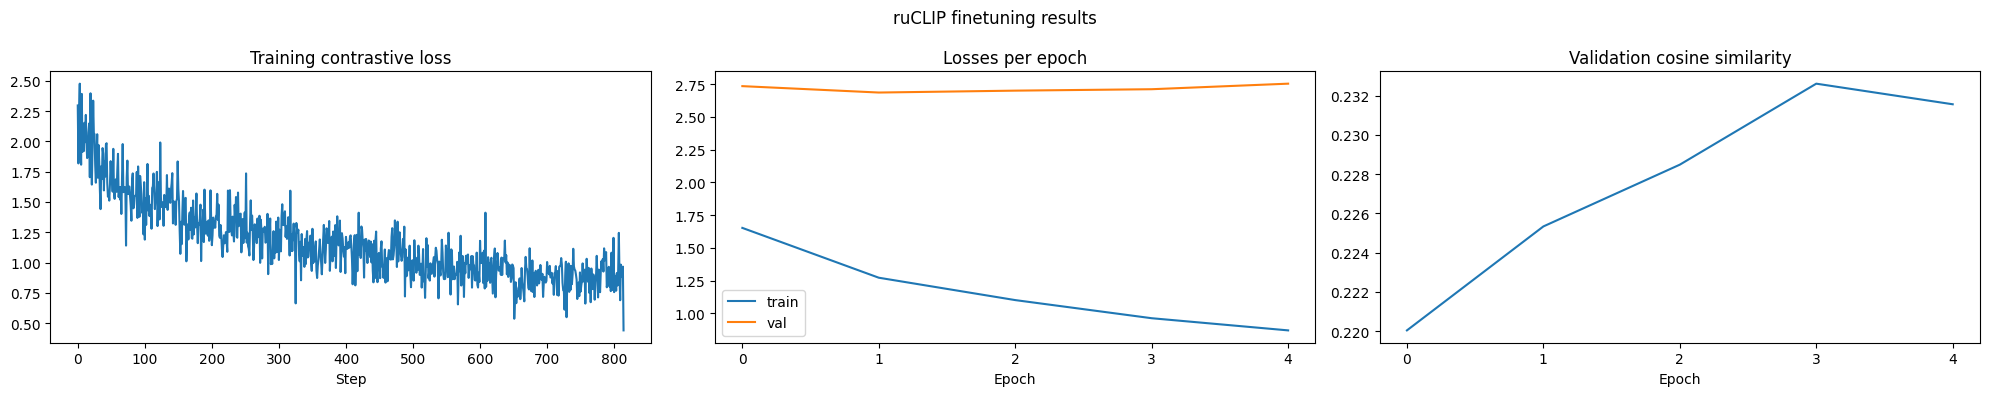

In [9]:
# визуализируем результаты обучения
utils.plot_training_logs(ruclip_logs, 'ruCLIP finetuning results', 'figures/ruclip-finetuning.png')

## Extraction of embeddings

In [10]:
# получаем эмбеддинги
test_df = pd.read_csv('data/test_data.csv')
total_image_embeddings, total_text_embeddings = utils.get_full_embeddings(test_df, model, processor, model_name, device)

test_data = {
    'ids': test_df['id'].to_list(),
    'image_paths': test_df['local_image_path'].to_list(),
    'image_embeddings': total_image_embeddings,
    'texts': test_df['text'].to_list(),
    'text_embeddings': total_text_embeddings,
    'urls': test_df['url'].to_list()
}

# сохраняем в пикл
with open('embeddings/test_embeddings_ruclip_finetuned.pkl', 'wb') as file:
    pickle.dump(test_data, file)

100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


## Evaluation

In [11]:
# загружаем тестовые эмбеддинги
with open('embeddings/test_embeddings_ruclip_finetuned.pkl', 'rb') as file:
    test_data = pickle.load(file)

# инициализируем модель
model_name = 'ruclip'
ruclip_model, preprocess = ruclip.load('ruclip-vit-base-patch32-224', device='cpu')
ruclip_model.load_state_dict(torch.load('models/ruclip_finetuned.pt', weights_only=True))

# считаем косинусное сходство между эмбеддингами правильных пар
utils.mean_similarity_between_true(ruclip_model, test_data['image_embeddings'], test_data['text_embeddings'])

/home/student/kholicheva/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


Среднее косинусное сходство эмбеддингов у правильных пар: 0.2305


0.23053468763828278

In [12]:
# проходим по всем тестовым запросам
queries_and_preds = {}
for query in queries:
    text_embedding = utils.get_text_embedding(query, model, preprocess, model_name, device)
    scores = torch.cosine_similarity(text_embedding, test_data['image_embeddings'], dim=-1)
    top_images_indices = torch.topk(scores, k=5).indices
    ids = np.array(test_data['ids'])[top_images_indices].tolist()
    paths = np.array(test_data['image_paths'])[top_images_indices].tolist()
    texts = np.array(test_data['texts'])[top_images_indices].tolist()
    queries_and_preds[query] = {'ids': ids, 'paths': paths, 'texts': texts}

In [13]:
utils.precision_at_k(queries_and_relevants, queries_and_preds)

----- Precision@5 -----
Запрос "котенок":  1.00
Запрос "петух курица":  1.00
Запрос "девушка":  0.80
Запрос "новый год":  0.80
Запрос "пасха":  1.00
Запрос "цветы ромашки":  1.00
Запрос "иероглифы":  0.80
Запрос "персонажи мультфильмов":  0.60
Запрос "космос":  1.00
Запрос "необычные птицы":  1.00
Запрос "ученый и наука":  0.40
Запрос "надписи буквами":  1.00
Запрос "военная":  0.20
Запрос "автомобили машины":  1.00
Запрос "гарри поттер":  1.00
Запрос "бабочка":  1.00
Запрос "собака играет":  0.60
Запрос "знаки зодиака":  1.00
Запрос "лило и стич":  1.00
Запрос "самолеты небо":  0.80
Запрос "детские рисунки":  0.20
Запрос "любовь":  0.80
Запрос "динозавр":  1.00
Запрос "пиво":  1.00
Среднее значение по всем запросам: 0.8333333333333334


In [14]:
utils.recall_at_k(queries_and_relevants, queries_and_preds)

----- Recall@5 -----
Запрос "котенок":  0.31
Запрос "петух курица":  0.31
Запрос "девушка":  0.29
Запрос "новый год":  0.29
Запрос "пасха":  0.33
Запрос "цветы ромашки":  0.33
Запрос "иероглифы":  0.57
Запрос "персонажи мультфильмов":  0.19
Запрос "космос":  0.28
Запрос "необычные птицы":  0.36
Запрос "ученый и наука":  0.22
Запрос "надписи буквами":  0.31
Запрос "военная":  0.07
Запрос "автомобили машины":  0.45
Запрос "гарри поттер":  0.83
Запрос "бабочка":  0.33
Запрос "собака играет":  0.19
Запрос "знаки зодиака":  0.31
Запрос "лило и стич":  0.33
Запрос "самолеты небо":  0.27
Запрос "детские рисунки":  0.07
Запрос "любовь":  0.22
Запрос "динозавр":  0.42
Запрос "пиво":  0.45
Среднее значение по всем запросам: 0.32248526936026933
